# Projeto #4: Classificação de texto

# Tarefa e Dados


<p align="justify">Descreva a tarefa escolhida e os dados. Escreva o código que leia os dados e calcule e imprima quantas instâncias os dados têm. Também, seu código deve calcular a média de tokens por instância, isto é, quantos tokens, na média cada documento do seu conjunto de dados possui. Imprima esse único número.</p>

### Base de dados escolhida:

<p align="justify">A base escolhida foi a <b>UTL Corpus</b> que é um conjunto de dados, em português, que contém críticas de filmes e apps coletadas automaticamente de sites.</p>

- **Nome da base**: UTLCorpus
- **Link base de dados**: https://drive.google.com/drive/folders/1xS6mWUWGL2v6GQQyxx6MIZNu1_2ZXjPe?usp=sharing
- **Link modelos**: https://drive.google.com/drive/folders/1cFV2yDM-J4f1t4iMvZXz_FVc68fQHSe4?usp=sharing
- **Repositório**: https://github.com/RogerFig/UTLCorpus
- **Artigo de referência**: https://repositorio.usp.br/item/002971317

<p align="justify">Esse corpus é uma coleção de resenhas extraídas de dois domínios: filmes e aplicativos. A base possui 15 atributos e 2.881.589 avaliações sendo 1.839.851 de filmes e 1.041.738 de aplicativos. O domínio utilizado nesse projeto será o de <b>aplicativos</b> e a tarefa será <b>classificação</b> binária cujo objetivo será dizer se uma avaliação é positiva ou negativa.</p>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Bibliotecas básicas

In [ ]:
!pip install spellchecker
!pip install pyspellchecker
!pip install scattertext
!python -m spacy download pt_core_news_sm
!pip install -U yellowbrick
!python -m spacy download pt

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

In [4]:
import numpy as np
import pandas as pd
import spacy

import warnings
warnings.filterwarnings('ignore')

%run '/content/gdrive/MyDrive/Colab Notebooks/aed_projeto_4/modules/data.py'

print(f'Versão Pandas: {pd.__version__}')
print(f'Versão Numpy: {np.__version__}')
print(f'Versão Spacy: {spacy.__version__}')

pd.set_option('display.float_format', lambda x: '%.3f' % x);

Versão Pandas: 1.1.4
Versão Numpy: 1.18.5
Versão Spacy: 2.2.4


### Bibliotecas de visualização

In [5]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.style.use(['ggplot'])

print(f'Versão Seaborn: {sns.__version__}')
print(f'Versão Matplotlib: {matplotlib.__version__}')

Versão Seaborn: 0.11.0
Versão Matplotlib: 3.2.2


### Dicionário dos dados

**domain**: domínio das resenhas

**object**: aplicativo avaliado

**author**: autor da avaliação (anonimizado)

**text**: texto da avaliação

**likes**: número de likes que a avaliação recebeu

**unlikes**: número de deslikes que a avaliação recebeu

**stars**: número de estrelas dada na avaliação

**date**: data da avaliação

**internal_id**: identificador

### Carregamento dos dados

In [6]:
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/aed_projeto_4/data/UTLCorpus.csv')
print(f'Linhas: {data.shape[0]} | Colunas: {data.shape[1]}')

Linhas: 2881589 | Colunas: 16


### Escolha do domínio

In [7]:
apps = data.query('domain=="apps"')
apps.drop(['Unnamed: 0', 'replies', 'favorite', 'want_see', 'recommend', 'see', 'collect_date'], axis=1, inplace=True)
apps.reset_index(drop=True, inplace=True)
print(f'Linhas: {apps.shape[0]} | Colunas: {apps.shape[1]}')

Linhas: 1041738 | Colunas: 9


### Características dos dados

In [8]:
apps.head()

,domain,object,author,text,likes,unlikes,stars,date,internal_id
0,apps,air.com.hypah.io.slither,0,"Adorei, podia melhorar em vários detalhes, por...",1100,0,5.000,22 de janeiro de 2019,0
1,apps,air.com.hypah.io.slither,1,"17 de março, estamos no ps4 jogando r6, e talv...",152,0,5.000,17 de março de 2019,1
2,apps,air.com.hypah.io.slither,2,É um jogo bom hzbsbbsbdjdjkaklloosjbsbzbsbhhHA...,0,0,5.000,3 de março de 2019,2
3,apps,air.com.hypah.io.slither,3,O jogo e mais o menos um pouco bom só que ele ...,0,0,2.000,1 de abril de 2019,3
4,apps,air.com.hypah.io.slither,4,0. JOGO. E. MUITO. CHATO. MAIS. E. RASUAVEL. V...,0,0,2.000,6 de abril de 2019,4


In [9]:
print(f'Colunas presentes: {apps.columns.values}')

Colunas presentes: ['domain' 'object' 'author' 'text' 'likes' 'unlikes' 'stars' 'date'
 'internal_id']


In [10]:
print(f'Tipos dos dados: {apps.dtypes.unique()}')

Tipos dos dados: [dtype('O') dtype('int64') dtype('float64')]


### Informação dos dados

In [11]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041738 entries, 0 to 1041737
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   domain       1041738 non-null  object 
 1   object       1041738 non-null  object 
 2   author       1041738 non-null  int64  
 3   text         1039542 non-null  object 
 4   likes        1041738 non-null  int64  
 5   unlikes      1041738 non-null  int64  
 6   stars        1041738 non-null  float64
 7   date         1041738 non-null  object 
 8   internal_id  1041738 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 71.5+ MB


### Descrição dos dados

In [12]:
apps.drop(['author', 'internal_id'], axis=1).describe()

,likes,unlikes,stars
count,1041738.000,1041738.000,1041738.000
mean,6.016,0.000,3.957
std,86.191,0.000,1.528
min,0.000,0.000,0.000
25%,0.000,0.000,3.000
50%,0.000,0.000,5.000
75%,0.000,0.000,5.000
max,20146.000,0.000,5.000


In [13]:
apps[['object', 'text', 'date']].describe(include='O')

,object,text,date
count,1041738,1039542,1041738
unique,233,809232,2879
top,br.com.vivo,muito bom,29 de março de 2019
freq,5080,17946,16863


### Valores nulos

In [14]:
data_missing = pd.DataFrame({'nomes': apps.columns, 
                             'tipos': apps.dtypes, 
                             'NA #': apps.isna().sum(),
                             'NA %': (apps.isna().sum() / apps.shape[0]) * 100
                            })

data_missing[data_missing['NA #'] > 0].set_index('nomes')

,tipos,NA #,NA %
nomes,,,
text,object,2196,0.211


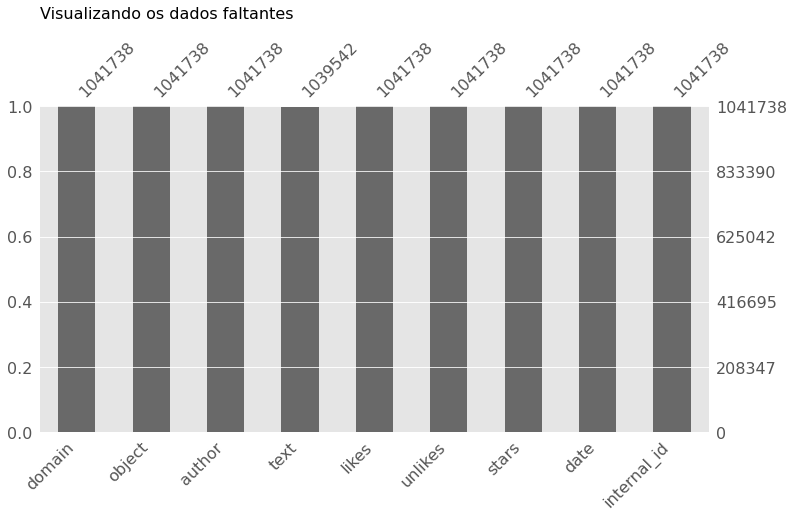

In [15]:
import missingno as msno

msno.bar(apps, figsize=[12, 6])
plt.title('Visualizando os dados faltantes', y=1.25, size=16, loc='left')
plt.show()

#### Remoção das linhas com texto nulos

In [16]:
apps.dropna(inplace=True)
print('Conferindo a remoção dos valores nulos: ')
apps.isna().sum()

Conferindo a remoção dos valores nulos: 


domain         0
object         0
author         0
text           0
likes          0
unlikes        0
stars          0
date           0
internal_id    0
dtype: int64

### Definição dos rótulos

<p align='justify'>Cada crítica tem uma pontuação de 0 a 5 estrelas:</p>

- 0 e 5: serão descartadas para evitar os casos em que as estrelas do usuário não são coerentes com o texto da avaliação.
 
- 1 e 2: negativa

- 3: serão descartadas, porque geralmente contêm opiniões positivas e negativas.

- 4: positiva

<p align='justify'>Baseada na metodologia explicada neste artigo: <a href='https://www.teses.usp.br/teses/disponiveis/55/55134/tde-24032016-171420/pt-br.php'>Sobre normalização e classificação de polaridade de textos opinativos na web</a></p>

#### Distribuição das estrelas

In [17]:
apps['stars'].value_counts()

5.000    632365
1.000    170877
4.000    118379
3.000     70677
2.000     47237
0.000         7
Name: stars, dtype: int64

#### Exemplo de opinião negativa e positiva no mesmo texto

In [18]:
print(apps[apps.index==92][['text', 'stars']].values[0])

['O jogo é bom, mas ele tem muita propaganda e além disso ele trava demais'
 3.0]


#### Exemplo de texto em que a estrela do usuário não é coerente com o texto

In [19]:
print(apps[apps.index==319073][['text', 'stars']].values[0])

['Gostei, acompanho vários esportes no msm lugar. Funfa muito bem no Galaxy S'
 0.0]


#### Seleção das classificações com 1, 2 e 4 estrelas

In [20]:
apps = apps.query('stars==1 or stars==2 or stars==4')
apps.reset_index(drop=True, inplace=True)
print(f'Linhas: {apps.shape[0]} | Colunas: {apps.shape[1]}')

Linhas: 336493 | Colunas: 9


#### Criação dos rótulos para as classificações

In [21]:
labels_map = {1 : 'negativo', 2: 'negativo', 4: 'positivo'}
apps['rating'] = apps['stars'].map(labels_map)
apps['rating'].value_counts()

negativo    218114
positivo    118379
Name: rating, dtype: int64

### Exemplos dos textos

In [22]:
printExample(4, apps)

Text: Eu quero que arrume tem muito comerciais falças quando você acaba de perde quando você sai ai tem comerciais eu ficou unvido musica com esse jogo quando chegar outro comeciau ele pausa a musica
Rating: negativo
Stars: 1.0


In [23]:
printExample(0, apps)

Text: O jogo e mais o menos um pouco bom só que ele fica travando muito no meu celula ñ curti muito mais dou duas estrelas
Rating: negativo
Stars: 2.0


In [24]:
printExample(2, apps)

Text: sabe o jogo é muito bom tem feito um sucesso imenso, não quero choramingar mas quando a gente esta no nível supremo e alguem mata vc é de ficar puto da vida
Rating: positivo
Stars: 4.0


### Amostragem dos dados

<p align='justify'>Devido ao custo computacional, será usada apenas uma amostra 10.000 dados.</p>

In [25]:
apps = apps.groupby(['rating']).apply(lambda x : x.sample(n=10000, replace=False))
apps.reset_index(drop=True, inplace=True)
print(apps['rating'].value_counts())

negativo    10000
positivo    10000
Name: rating, dtype: int64


### Limpeza dos dados

In [26]:
# from tqdm import tqdm

# for text in tqdm(apps['text']):
#     apps['text'] = apps['text'].apply(cleaning)
    
# apps.to_csv('data/data_cleaned.csv', index=False)

### Dados pré-processados

In [27]:
apps = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/aed_projeto_4/data/data_cleaned.csv')
print(f'Linhas: {apps.shape[0]} | Colunas: {apps.shape[1]}')

Linhas: 10000 | Colunas: 11


### Seleção de features

In [28]:
apps = apps.drop(['text', 'author', 'date', 'internal_id', 'likes', 'object', 'stars', 'unlikes', 'domain'], axis=1)
print(f'Linhas: {apps.shape[0]} | Colunas: {apps.shape[1]}')
apps.head()

Linhas: 10000 | Colunas: 2


,rating,clean_text
0,negativo,jogo bom porem nao conseguindo conectar mundo ...
1,negativo,tentei criar video vezes selecionar fotos musi...
2,negativo,faz celular travar
3,negativo,gosto assistir fazenda mais nao pra assistir vivo
4,negativo,fiz assinatura mas nao atendeu efetuei cancela...


### Embaralhamento dos dados

In [29]:
apps = apps.iloc[np.random.permutation(apps.index)].reset_index(drop=True)

### Análise N-grams

In [30]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['font.family'] = 'Arial, Helvetica, sans-serif'

#### Unigrams

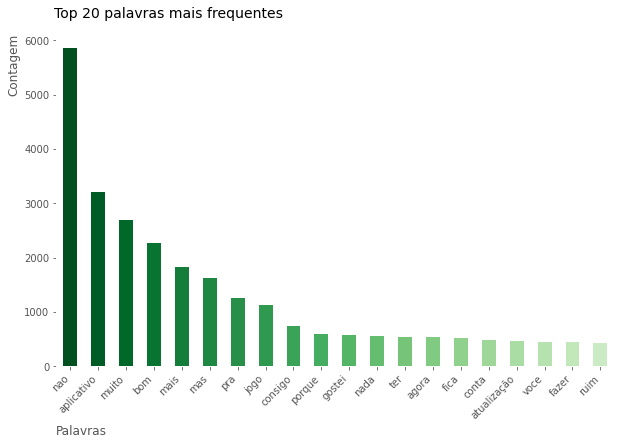

In [31]:
common_words = getTopNwords(apps['clean_text'])
uni = pd.DataFrame(common_words, columns = ['texto' , 'contagem'])

_, ax= plt.subplots()
uni.groupby('texto').sum()['contagem'].sort_values(ascending=False).plot(kind='bar', 
                                                                         color=sns.color_palette('Greens_r', n_colors=25), 
                                                                         figsize=[10, 6])

plt.title('Top 20 palavras mais frequentes', y=1.05, size=14, loc='left', x=-0.005)
plt.ylabel('Contagem', horizontalalignment='left', y=0.83)
plt.xlabel('Palavras', horizontalalignment='right', x=0.09)  
plt.ylim(0, 6000)
ax.set_xticklabels(uni['texto'], rotation=45, ha='right')
plt.show()

#### Bigrams

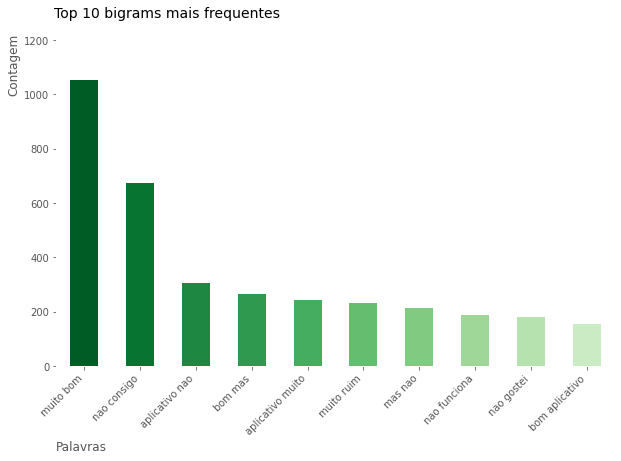

In [32]:
common_words = getTopNwords(apps['clean_text'], 2, 10)
bi = pd.DataFrame(common_words, columns = ['texto' , 'contagem'])

_, ax= plt.subplots()
bi.groupby('texto').sum()['contagem'].sort_values(ascending=False).plot(kind='bar', 
                                                                         color=sns.color_palette('Greens_r', n_colors=12), 
                                                                         figsize=[10, 6])

plt.title('Top 10 bigrams mais frequentes', y=1.05, size=14, loc='left', x=-0.005)
plt.ylabel('Contagem', horizontalalignment='left', y=0.83)
plt.xlabel('Palavras', horizontalalignment='right', x=0.09)  
plt.ylim(0, 1200)
ax.set_xticklabels(bi['texto'], rotation=45, ha='right')
plt.show()

#### Trigrams

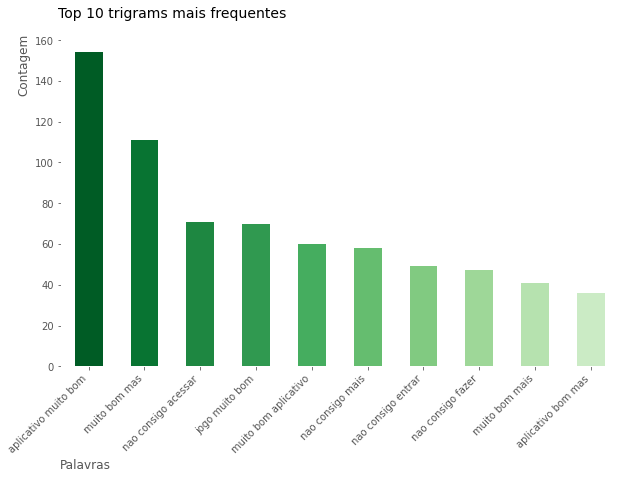

In [33]:
common_words = getTopNwords(apps['clean_text'], 3, 10)
tri = pd.DataFrame(common_words, columns = ['texto' , 'contagem'])

_, ax= plt.subplots()
tri.groupby('texto').sum()['contagem'].sort_values(ascending=False).plot(kind='bar', 
                                                                         color=sns.color_palette('Greens_r', n_colors=12), 
                                                                         figsize=[10, 6])

plt.title('Top 10 trigrams mais frequentes', y=1.05, size=14, loc='left', x=-0.005)
plt.ylabel('Contagem', horizontalalignment='left', y=0.83)
plt.xlabel('Palavras', horizontalalignment='right', x=0.09)  
plt.ylim(0, 160)
ax.set_xticklabels(tri['texto'], rotation=45, ha='right')
plt.show()

### Encontrando termos característicos e suas associações

In [ ]:
import scattertext as st

nlp = spacy.load('pt')
corpus = st.CorpusFromPandas (apps, category_col='rating', text_col='clean_text', nlp=nlp).build()

#### Termos mais característicos do corpus

In [ ]:
print(list(corpus.get_scaled_f_scores_vs_background().index[:50]))

#### Termos mais associados à classe negativo

In [36]:
term_freq_df = corpus.get_term_freq_df() 
term_freq_df['negativo'] = corpus.get_scaled_f_scores('negativo') 
print(list(term_freq_df.sort_values(by='negativo', ascending=False).index[:10]))

['bosta', 'nao recomendo', 'péssimo', 'pior', 'consigo acessar', 'lixo', 'horrivel', 'muito ruim', 'cadastro', 'odiei']


#### Termos mais associados à classe positivo

In [37]:
term_freq_df['positivo'] = corpus.get_scaled_f_scores('positivo') 
print(list(term_freq_df.sort_values(by='positivo', ascending=False).index[:10]))

['adorei', 'bom aplicativo', 'ter mais', 'muito bom', 'muito util', 'otimo aplicativo', 'poderia ter', 'ter opção', 'estrelas porque', 'facil']


### Média de tokens por instância

In [38]:
average = averageTokens(apps, 'clean_text')
print(f'Média dos tokens por instância: {round(average, 2)}')

Média dos tokens por instância: 11.19


### Encoder

In [39]:
X = apps.drop(['rating'], axis=1)
y = apps['rating']

In [40]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)
print('Labels: ', len(le.classes_))

Labels:  2


### Separação treino e teste

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=85, shuffle=True)
print(f'X_train: {X_train.shape} | X_test: {X_test.shape}')
print(f'y_train: {y_train.shape} | y_test: {y_test.shape}')

X_train: (8000, 1) | X_test: (2000, 1)
y_train: (8000,) | y_test: (2000,)


# Visualização dos dados
<p align="justify">Coloque nesta seção os gráficos do PCA e do t-SNE, para cada representação. Responda também às seguintes perguntas:</p>


- a) Existe algum padrão com relação às classes? 
- b) Caso exista algum padrão, você pode concluir alguma coisa? 
- c) Caso não exista, você consegue dizer se isso tem a ver com alguma representação ou classe?

#### TF-IDF

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps = [
  ('tfidf', TfidfVectorizer(stop_words=STOPWORDS)),
  ('standard', StandardScaler(with_mean=False))
])

vectors = pipe.fit_transform(X_train['clean_text'])

### Word2vec

#### Treinamento do novo modelo


In [45]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

tokens = []
for idx, text in enumerate(X_train['clean_text']):
  tok_lst = nltk.word_tokenize(text)
  tokens.append([tok for tok in tok_lst if tok not in STOPWORDS and len(tok) > 1])

model = Word2Vec(size=300, window=2, min_count=1, workers=4)
model.build_vocab(tokens, progress_per=10000)

model.train(tokens, total_examples=model.corpus_count, epochs=10)
word_vectors = model.wv
word_vectors.save('/content/gdrive/MyDrive/Colab Notebooks/aed_projeto_4/model/word2vec.wordvectors')

#### Embbedings

In [ ]:
model_w2v = KeyedVectors.load('/content/gdrive/MyDrive/Colab Notebooks/aed_projeto_4/model/word2vec.wordvectors')
features = []

for idx, text in enumerate(X_train['clean_text']):
  tok_lst = nltk.word_tokenize(text)
  tok_lst = [tok for tok in tok_lst if tok not in STOPWORDS and len(tok) > 1]

  ntok = 0
  doc = np.zeros((300, ))

  for tok in tok_lst:
    if tok in model_w2v:
      doc = np.add(doc, model_w2v[tok])
      ntok += 1
  features.append(doc/ntok)

features = np.array(features)
features[np.isnan(features)] = 0

### Extração de features do texto

#### Polaridade, tamanho texto e total de palavras

In [47]:
from textblob import TextBlob

infoText = {'POLARITY' : [], 'TAMANHO_TEXTO': [], 'CONTAGEM_PALAVRAS' : []}

for idx, text in enumerate(X_train['clean_text']):
  infoText['POLARITY'].append(TextBlob(text).sentiment.polarity)
  infoText['TAMANHO_TEXTO'].append(len(text))
  infoText['CONTAGEM_PALAVRAS'].append(len(text.split()))

#### Pós tagging

In [48]:
model = spacy.load('pt')
model_docs = []
pos_features = {'VERB':[],'ADJ':[],'NOUN':[],'ADV':[]}

for idx, text in enumerate(X_train['clean_text']):
  model_docs.append(model(text))

for doc in model_docs:  
    verb, adj, noun, adv = 0, 0, 0, 0
    num_palavras = len(doc)
    
    for tok in doc:
        if tok.pos_ == 'VERB':
            verb += 1
        if tok.pos_ == 'ADJ':
            adj += 1
        if tok.pos_ == 'NOUN':
            noun += 1
        if tok.pos_ == 'ADV':
            adv += 1

    pos_features['VERB'].append(verb/num_palavras)
    pos_features['ADJ'].append(adj/num_palavras)
    pos_features['NOUN'].append(noun/num_palavras)
    pos_features['ADV'].append(adv/num_palavras)

#### Análise de sentimento

In [49]:
dicionario_emotaix = {'ÓDIO':[], 'AGRESSIVIDADE':[], 'AFEIÇÃO':[], 'GENTILEZA':[]}
fd_emotaix = open('/content/gdrive/MyDrive/Colab Notebooks/aed_projeto_4/model/Emotaix-pt .csv','r')
header = fd_emotaix.readline()

for line in fd_emotaix:
    entry = line.replace('\n','').split(",")
    if entry[2] in dicionario_emotaix:
        dicionario_emotaix[entry[2]].append(entry[0])

emotaix_features = {'ÓDIO':[],'AGRESSIVIDADE':[],'AFEIÇÃO':[],'GENTILEZA':[]}

for doc in model_docs:
    odio, agressividade, afeicao, gentileza = 0, 0, 0, 0
    for tok in doc:
        if tok.text in dicionario_emotaix['ÓDIO']:
            odio += 1
        if tok.text in dicionario_emotaix['AGRESSIVIDADE']:
            agressividade += 1
        if tok.text in dicionario_emotaix['AFEIÇÃO']:
            afeicao += 1
        if tok.text in dicionario_emotaix['GENTILEZA']:
            gentileza += 1
            
    emotaix_features['ÓDIO'].append(odio/len(doc))
    emotaix_features['AGRESSIVIDADE'].append(agressividade/len(doc))
    emotaix_features['AFEIÇÃO'].append(afeicao/len(doc))
    emotaix_features['GENTILEZA'].append(gentileza/len(doc))

#### Juntando as novas features

In [50]:
data = {}
data_lst = [pos_features, emotaix_features, infoText]

for ftr in data_lst:
    for k in ftr:
        data[k] = ftr[k]

df = pd.DataFrame(data)
df.tail()

,VERB,ADJ,NOUN,ADV,ÓDIO,AGRESSIVIDADE,AFEIÇÃO,GENTILEZA,POLARITY,TAMANHO_TEXTO,CONTAGEM_PALAVRAS
7995,0.273,0.091,0.455,0.000,0.000,0.000,0.000,0.000,0.000,80,11
7996,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,7,1
7997,0.263,0.105,0.316,0.053,0.000,0.000,0.000,0.000,0.000,139,19
7998,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,15,2
7999,0.600,0.000,0.200,0.200,0.000,0.000,0.000,0.000,0.000,36,5


### PCA

#### TF-IDF

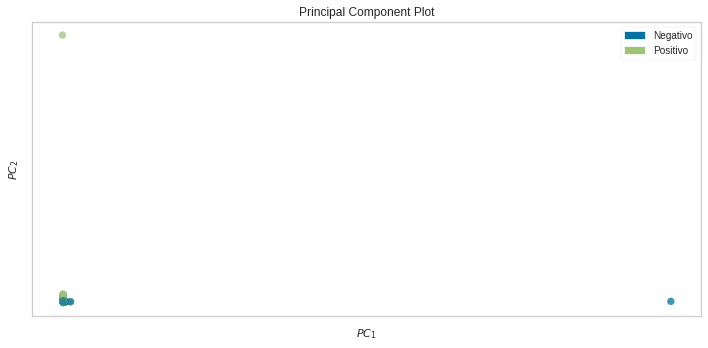

In [51]:
from yellowbrick.features import PCA

fig, ax = plt.subplots(figsize=(10, 5))
classes = ['Negativo', 'Positivo']

visualizer = PCA(scale=True, classes=classes)
visualizer.fit_transform(vectors.toarray(), y_train)
ax.grid(False)
visualizer.show();

#### Word2vec

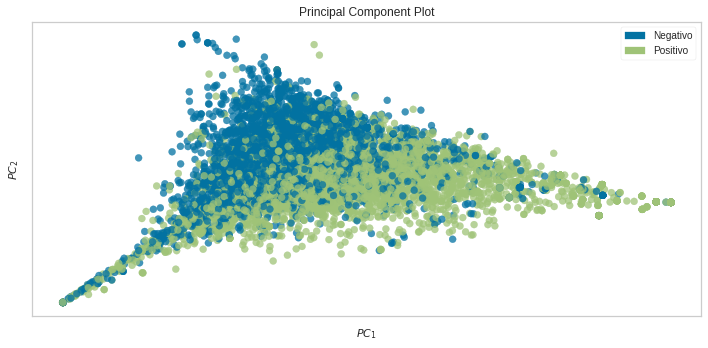

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
classes = ['Negativo', 'Positivo']

visualizer = PCA(scale=True, classes=classes)
visualizer.fit_transform(features, y_train)
ax.grid(False)
visualizer.show();

#### Extração de features

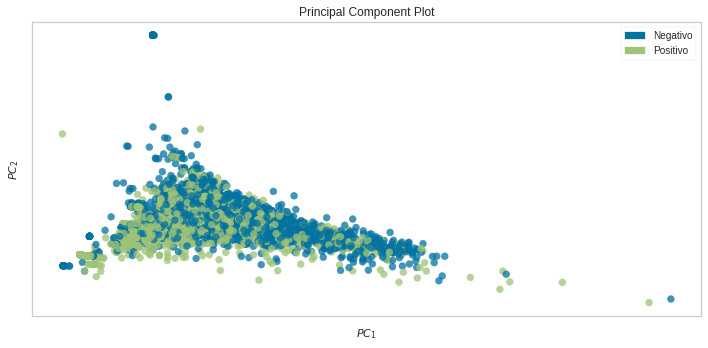

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))
classes = ['Negativo', 'Positivo']

visualizer = PCA(scale=True, classes=classes)
visualizer.fit_transform(df, y_train)
ax.grid(False)
visualizer.show();

### T-SNE

#### TF-IDF

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


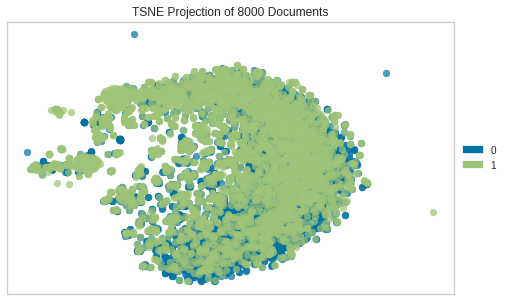

In [54]:
from yellowbrick.text import TSNEVisualizer

fig, ax = plt.subplots(figsize=(10, 5))
tsne = TSNEVisualizer(labels=[0, 1])
tsne.fit(vectors.toarray(), y_train)
tsne.show();

#### Word2vec

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


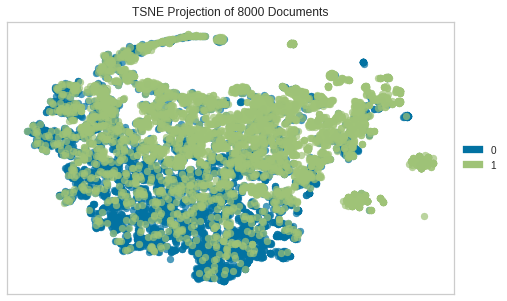

In [55]:
fig, ax = plt.subplots(figsize=(10, 5))
tsne = TSNEVisualizer(labels=[0, 1])
tsne.fit(features, y_train)
tsne.show();

#### Extração de features

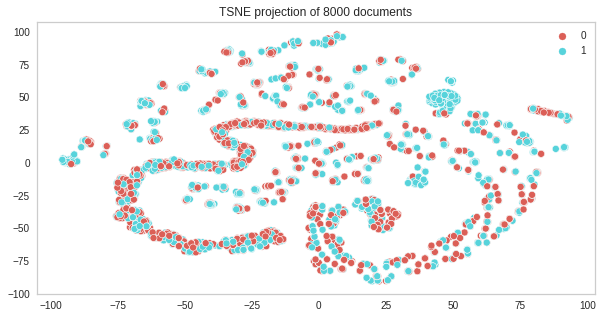

In [56]:
from sklearn.manifold import TSNE

tsne = TSNE()
df_tsne = tsne.fit_transform(df)

palette = np.array(sns.color_palette('hls', 2))
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(df_tsne[:,0], df_tsne[:,1], legend='full', hue=y_train, palette=palette)
ax.grid(False)
plt.title('TSNE projection of 8000 documents')
plt.show()

**Análise:** <p align="justify">Com base na amostra dos dados, é possível perceber que eles parecem bem similares, com exceção de alguns pontos que ficaram mais afastados. Isso faz sentido, uma vez que o contexto dessas classificações são bastante parecidos.</p>



# Classificadores


<p align="justify">Descreva sucintamente os dois classificadores escolhidos. Você usou algum parâmetro que não seja padrão? Se sim, mencione nesta seção.</p>

<p align="justify">Para essa tarefa foram escolhidos dois classificadores: </p>

- **Naive Bayes:** <p align="justify">Por ser um modelo bem popular para classificação de textos e por ser eficiente para pequenas amostras, uma vez que supõe uma independência entre os atributos.</p>

- **Random Forest:** <p align="justify">Por ser uma execelente ferramenta para tarefas de classificação e por usar bagging para corrigir a tendência à superadequação, o que traz bons resultados.</p>


# Resultados


<p align="justify">Escreva código que execute a validação cruzada em 5-folds para os dois classificadores escolhidos. Também responda às seguintes perguntas:</p>

- Os embeddings realmente mostraram um resultado melhor que o TF-IDF? 
- Se não, qual foi a representação que teve o melhor desempenho? 
- A diferença foi muito grande?

In [59]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

#### TF-IDF

##### Naive Bayes

In [60]:
model_NB = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(stop_words=STOPWORDS)),
        ('standard', StandardScaler(with_mean=False)),
        ('clf', MultinomialNB(alpha=1000))
])

###### Validação cruzada

In [61]:
scores = cross_val_score(model_NB, X_train['clean_text'], y_train, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.77 (+/- 0.02)


###### Métricas

In [62]:
model_NB.fit(X_train['clean_text'], y_train)
y_pred_NB = model_NB.predict(X_test['clean_text'])
print(classification_report(y_test, y_pred_NB, target_names=le.classes_.tolist()))

              precision    recall  f1-score   support

    negativo       0.75      0.84      0.79      1001
    positivo       0.82      0.72      0.77       999

    accuracy                           0.78      2000
   macro avg       0.79      0.78      0.78      2000
weighted avg       0.79      0.78      0.78      2000



###### Matriz de confusão

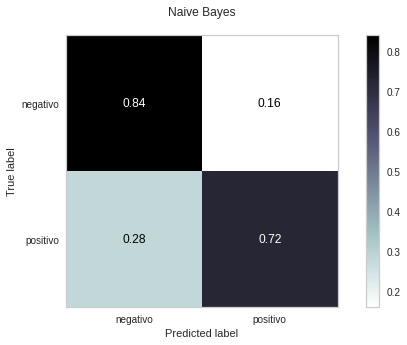

In [63]:
np.set_printoptions(precision=2)

plt.rcParams['figure.figsize'] = [10, 5]
disp = plot_confusion_matrix(model_NB, 
                             X_test['clean_text'], 
                             y_test, 
                             display_labels=le.classes_.tolist(),
                             cmap=plt.cm.bone_r, 
                             normalize='true')

disp.ax_.set_title('Naive Bayes', y=1.05)
disp.ax_.grid(False)
plt.show()

##### Random Forest

In [64]:
model_RF = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(stop_words=STOPWORDS)),
        ('standard', StandardScaler(with_mean=False)),
        ('clf', RandomForestClassifier(n_estimators=300, criterion='gini'))
])

###### Validação cruzada

In [65]:
scores = cross_val_score(model_RF, X_train['clean_text'], y_train, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.82 (+/- 0.02)


###### Métricas

In [66]:
model_RF.fit(X_train['clean_text'], y_train)
y_pred_RF = model_RF.predict(X_test['clean_text'])
print(classification_report(y_test, y_pred_RF, target_names=le.classes_.tolist()))

              precision    recall  f1-score   support

    negativo       0.79      0.86      0.82      1001
    positivo       0.85      0.77      0.81       999

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



###### Matriz de confusão

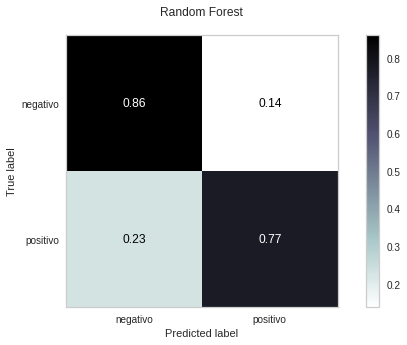

In [67]:
np.set_printoptions(precision=2)

plt.rcParams['figure.figsize'] = [10, 5]
disp = plot_confusion_matrix(model_RF, 
                             X_test['clean_text'], 
                             y_test, 
                             display_labels=le.classes_.tolist(),
                             cmap=plt.cm.bone_r, 
                             normalize='true')

disp.ax_.set_title('Random Forest', y=1.05)
disp.ax_.grid(False)
plt.show()

#### Word2Vec

In [68]:
train = features

test = []

for idx, text in enumerate(X_test['clean_text']):
  tok_lst = nltk.word_tokenize(text)
  tok_lst = [tok for tok in tok_lst if tok not in STOPWORDS and len(tok) > 1]

  ntok = 0
  doc = np.zeros((300, ))
  for tok in tok_lst:
    if tok in model_w2v:
      doc = np.add(doc, model_w2v[tok])
      ntok += 1
  test.append(doc/ntok)

test = np.array(test)
test[np.isnan(test)] = 0

##### Naive Bayes

In [69]:
from sklearn.preprocessing import MinMaxScaler

model_NB = Pipeline(steps=[
        ('minMax', MinMaxScaler()),
        ('clf', MultinomialNB(alpha=1000))
])

###### Validação cruzada

In [70]:
scores = cross_val_score(model_NB, train, y_train, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.72 (+/- 0.02)


###### Métricas

In [71]:
model_NB.fit(train, y_train)
y_pred_NB = model_NB.predict(test)
print(classification_report(y_test, y_pred_NB, target_names=le.classes_.tolist()))

              precision    recall  f1-score   support

    negativo       0.67      0.83      0.74      1001
    positivo       0.78      0.58      0.67       999

    accuracy                           0.71      2000
   macro avg       0.72      0.71      0.70      2000
weighted avg       0.72      0.71      0.70      2000



###### Matriz de confusão

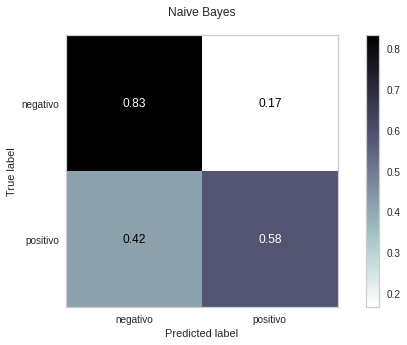

In [72]:
np.set_printoptions(precision=2)

plt.rcParams['figure.figsize'] = [10, 5]
disp = plot_confusion_matrix(model_NB, 
                             test, 
                             y_test, 
                             display_labels=le.classes_.tolist(),
                             cmap=plt.cm.bone_r, 
                             normalize='true')

disp.ax_.set_title('Naive Bayes', y=1.05)
disp.ax_.grid(False)
plt.show()

##### Random Forest

In [73]:
model_RF = Pipeline(steps=[
        ('clf', RandomForestClassifier(n_estimators=300, criterion='gini'))
])

###### Validação cruzada

In [74]:
scores = cross_val_score(model_RF, train, y_train, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.79 (+/- 0.02)


###### Métricas

In [75]:
model_RF.fit(train, y_train)
y_pred_RF = model_RF.predict(test)
print(classification_report(y_test, y_pred_RF, target_names=le.classes_.tolist()))

              precision    recall  f1-score   support

    negativo       0.78      0.80      0.79      1001
    positivo       0.79      0.78      0.78       999

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



###### Matriz de confusão

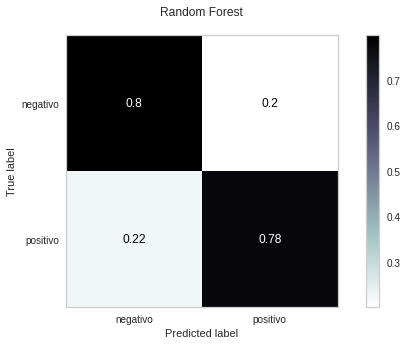

In [76]:
np.set_printoptions(precision=2)

plt.rcParams['figure.figsize'] = [10, 5]
disp = plot_confusion_matrix(model_RF, 
                             test, 
                             y_test, 
                             display_labels=le.classes_.tolist(),
                             cmap=plt.cm.bone_r, 
                             normalize='true')

disp.ax_.set_title('Random Forest', y=1.05)
disp.ax_.grid(False)
plt.show()

#### Extração de features

In [77]:
infoText = {'POLARITY' : [], 'TAMANHO_TEXTO': [], 'CONTAGEM_PALAVRAS' : []}
emotaix_features = {'ÓDIO':[],'AGRESSIVIDADE':[],'AFEIÇÃO':[],'GENTILEZA':[]}
pos_features = {'VERB':[],'ADJ':[],'NOUN':[],'ADV':[]}


for idx, text in enumerate(X_test['clean_text']):
  infoText['POLARITY'].append(TextBlob(text).sentiment.polarity)
  infoText['TAMANHO_TEXTO'].append(len(text))
  infoText['CONTAGEM_PALAVRAS'].append(len(text.split()))


model_docs = []
for idx, text in enumerate(X_test['clean_text']):
  model_docs.append(model(text))


for doc in model_docs:  
    verb, adj, noun, adv = 0, 0, 0, 0
    num_palavras = len(doc)
    
    for tok in doc:
        if tok.pos_ == 'VERB':
            verb += 1
        if tok.pos_ == 'ADJ':
            adj += 1
        if tok.pos_ == 'NOUN':
            noun += 1
        if tok.pos_ == 'ADV':
            adv += 1

    pos_features['VERB'].append(verb/num_palavras)
    pos_features['ADJ'].append(adj/num_palavras)
    pos_features['NOUN'].append(noun/num_palavras)
    pos_features['ADV'].append(adv/num_palavras)



for doc in model_docs:
    odio, agressividade, afeicao, gentileza = 0, 0, 0, 0
    for tok in doc:
        if tok.text in dicionario_emotaix['ÓDIO']:
            odio += 1
        if tok.text in dicionario_emotaix['AGRESSIVIDADE']:
            agressividade += 1
        if tok.text in dicionario_emotaix['AFEIÇÃO']:
            afeicao += 1
        if tok.text in dicionario_emotaix['GENTILEZA']:
            gentileza += 1
            
    emotaix_features['ÓDIO'].append(odio/len(doc))
    emotaix_features['AGRESSIVIDADE'].append(agressividade/len(doc))
    emotaix_features['AFEIÇÃO'].append(afeicao/len(doc))
    emotaix_features['GENTILEZA'].append(gentileza/len(doc))


data = {}
data_lst = [pos_features, emotaix_features, infoText]

for ftr in data_lst:
    for k in ftr:
        data[k] = ftr[k]

test = pd.DataFrame(data)

##### Naive Bayes

In [78]:
model_NB = Pipeline(steps=[
        ('minMax', MinMaxScaler()),
        ('clf', MultinomialNB(alpha=1000))
])

###### Validação cruzada

In [79]:
scores = cross_val_score(model_NB, df, y_train, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.65 (+/- 0.03)


###### Métricas

In [80]:
model_NB.fit(df, y_train)
y_pred_NB = model_NB.predict(test)
print(classification_report(y_test, y_pred_NB, target_names=le.classes_.tolist()))

              precision    recall  f1-score   support

    negativo       0.62      0.75      0.68      1001
    positivo       0.68      0.53      0.60       999

    accuracy                           0.64      2000
   macro avg       0.65      0.64      0.64      2000
weighted avg       0.65      0.64      0.64      2000



###### Matriz de confusão

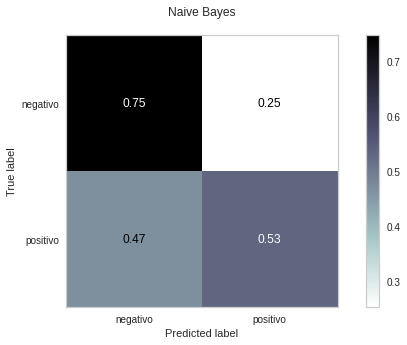

In [81]:
np.set_printoptions(precision=2)

plt.rcParams['figure.figsize'] = [10, 5]
disp = plot_confusion_matrix(model_NB, 
                             test, 
                             y_test, 
                             display_labels=le.classes_.tolist(),
                             cmap=plt.cm.bone_r, 
                             normalize='true')

disp.ax_.set_title('Naive Bayes', y=1.05)
disp.ax_.grid(False)
plt.show()

##### Random Forest

In [82]:
model_RF = Pipeline(steps=[
        ('clf', RandomForestClassifier(n_estimators=300, criterion='gini'))
])

###### Validação cruzada

In [83]:
scores = cross_val_score(model_RF, df, y_train, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.66 (+/- 0.02)


###### Métricas

In [84]:
model_RF.fit(df, y_train)
y_pred_RF = model_RF.predict(test)
print(classification_report(y_test, y_pred_RF, target_names=le.classes_.tolist()))

              precision    recall  f1-score   support

    negativo       0.64      0.66      0.65      1001
    positivo       0.65      0.63      0.64       999

    accuracy                           0.64      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.64      0.64      0.64      2000



###### Matriz de confusão

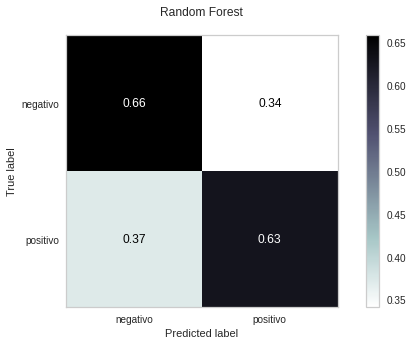

In [85]:
np.set_printoptions(precision=2)

plt.rcParams['figure.figsize'] = [10, 5]
disp = plot_confusion_matrix(model_RF, 
                             test, 
                             y_test, 
                             display_labels=le.classes_.tolist(),
                             cmap=plt.cm.bone_r, 
                             normalize='true')

disp.ax_.set_title('Random Forest', y=1.05)
disp.ax_.grid(False)
plt.show()

# Conclusão


<p align="justify">Por fim, fale aqui o que você conclui das visualizações e dos resultados. Tente explicar em detalhes por que um resultado, na sua opinião, foi melhor do que outro. Esta explicação pode incluir hipóteses para resultados melhores ou resultados piores. Também pode falar das dificuldades enfrentadas durante o trabalho e como conseguiu contorná-las.</p>